### todo:
- add water masking using WOs
    - https://github.com/GeoscienceAustralia/dea-notebooks/blob/develop/DEA_products/DEA_Fractional_Cover.ipynb
- refine cloud and shadow masking for landsat sensors
- try adding landsat 7 to see what happens
- test in cloudy area
- test in area pre landsat-8

In [1]:
%pip uninstall fc -y


Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install git+https://github.com/GeoscienceAustralia/fc.git -q


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import yaml
import json
import warnings
import datacube
import numpy as np
import xarray as xr
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from fc.fractional_cover import (
    fractional_cover,
)  # import the FC package after installing it above

from odc.geo.xr import assign_crs
from odc.geo.geom import Geometry
from odc.algo import keep_good_only
from odc.algo._percentile import xr_quantile_bands
from odc.algo._masking import _fuse_mean_np, _fuse_or_np, _xr_fuse, mask_cleanup
from datacube.model import Measurement
from datacube.utils import unsqueeze_dataset, masking

import sys

sys.path.insert(1, "/home/jovyan/dev/Tools/")
from dea_tools.datahandling import load_ard, wofs_fuser
from dea_tools.dask import create_local_dask_cluster
from dea_tools.plotting import rgb, plot_wo

warnings.filterwarnings("ignore")


In [ ]:
client = create_local_dask_cluster(return_client=True)


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jenna.guffogg@ga.gov.au/proxy/8787/status,
Dashboard: /user/jenna.guffogg@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 15,Total memory: 114.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43301,Workers: 1
Dashboard: /user/jenna.guffogg@ga.gov.au/proxy/8787/status,Total threads: 15
Started: Just now,Total memory: 114.00 GiB
Comm: tcp://127.0.0.1:37793,Total threads: 15
Dashboard: /user/jenna.guffogg@ga.gov.au/proxy/39105/status,Memory: 114.00 GiB
Nanny: tcp://127.0.0.1:43125,


2025-08-11 05:01:59,321 - distributed.nanny - WARNING - Restarting worker


In [ ]:
# save outputs


In [ ]:
def run_fc_multi(nbart: xr.Dataset, measurements, regression_coefficients):
    results = []
    times = nbart.time.values
    for t in times:
        # Select one time slice and remove the time dimension
        input_tile = nbart.sel(time=t)
        if "time" in input_tile.dims:
            input_tile = input_tile.squeeze("time").drop("time")
        data = fractional_cover(input_tile, measurements, regression_coefficients)
        # Add time back in
        output_tile = unsqueeze_dataset(data, "time", t)
        results.append(output_tile)
    # Concatenate along time
    combined = xr.concat(results, dim="time")
    return combined


In [ ]:
MEASUREMENTS = [
    {
        "name": "BS",
        "src_var": "BS",
        "units": "percent",
        "dtype": "int8",
        "nodata": -1,
        "zlib": True,
        "fletcher32": True,
        "attrs": {
            "long_name": "Bare ground fraction percentage",
            "comment": "Fraction of bare ground including rock, bare and disturbed soil, within the Landsat pixel as percentages",
            "alias": "bare",
            "coverage_content_type": "modelResult",
        },
        "aliases": ["bare"],
    },
    {
        "name": "PV",
        "src_var": "PV",
        "units": "percent",
        "dtype": "int8",
        "nodata": -1,
        "zlib": True,
        "fletcher32": True,
        "attrs": {
            "long_name": "Green cover fraction percentage",
            "comment": "Fraction of green cover including green groundcover and green leaf material over all strata, within the Landsat pixel, as percentages",
            "alias": "green",
            "coverage_content_type": "modelResult",
        },
        "aliases": ["green_veg"],
    },
    {
        "name": "NPV",
        "src_var": "NPV",
        "units": "percent",
        "dtype": "int8",
        "nodata": -1,
        "zlib": True,
        "fletcher32": True,
        "attrs": {
            "long_name": "Non-green cover fraction percentage",
            "comment": "Fraction of non green cover including litter, dead leaf and branches over all strata, within the Landsat pixel, as percentages",
            "alias": "dead",
            "coverage_content_type": "modelResult",
        },
        "aliases": ["dead_veg"],
    },
    {
        "name": "UE",
        "src_var": "UE",
        "units": "1",
        "dtype": "int8",
        "nodata": -1,
        "zlib": True,
        "fletcher32": True,
        "attrs": {
            "long_name": "Unmixing error",
            "comment": "Euclidean Norm of the Residual Vector",
            "alias": "err",
            "coverage_content_type": "qualityInformation",
        },
        "aliases": ["err"],
    },
]


In [ ]:
"""
You need to convert your MEASUREMENTS list of dicts into a list of objects that have a .name attribute.
If you want a quick fix, you can use a namedtuple:
"""

MEASUREMENTS_OBJ = [Measurement(**m) for m in MEASUREMENTS]


In [ ]:
LANDSAT_SENSOR_REGRESSION_COEFFICIENTS = {
    "blue": [0.00041, 0.97470],
    "green": [0.00289, 0.99779],
    "red": [0.00274, 1.00446],
    "nir": [0.00004, 0.98906],
    "swir1": [0.00256, 0.99467],
    "swir2": [-0.00327, 1.02551],
}

# SENTINEL_SENSOR_REGRESSION_COEFFICIENTS = {
#     "blue": [-22.0, 0.9551],
#     "green": [31.0, 1.0582],
#     "red": [64.0, 0.9871],
#     "nir": [120.0, 1.0187],
#     "swir1": [79.0, 0.9528],
#     "swir2": [-42.0, 0.9688],
# }


In [ ]:
LANDSAT_BAND_MAPPING = (
    {"load_bands": ("green", "red", "nir", "swir1", "swir2"), "rename": None},
    {
        "load_bands": (
            "nbart_green",
            "nbart_red",
            "nbart_nir",
            "nbart_swir_1",
            "nbart_swir_2",
        ),
        "rename": {
            "nbart_green": "green",
            "nbart_red": "red",
            "nbart_nir": "nir",
            "nbart_swir_1": "swir1",
            "nbart_swir_2": "swir2",
        },
    },
)


In [ ]:
SENTINEL_BAND_MAPPING = (
    {"load_bands": ("green", "red", "nir", "swir1", "swir2"), "rename": None},
    {
        "load_bands": (
            "nbart_green",
            "nbart_red",
            "nbart_nir_1",
            "nbart_swir_2",
            "nbart_swir_3",
        ),
        "rename": {
            "nbart_green": "green",
            "nbart_red": "red",
            "nbart_nir_1": "nir",
            "nbart_swir_2": "swir1",
            "nbart_swir_3": "swir2",
        },
    },
)


In [ ]:
# region_code = ['x176y085'] #marysville
# region_code = ['x168y092'] #hopetoun
# region_code = ['x140y138'] #west macdonnell
# region_codes = ['x148y166'] #limmen NT - cloud heavy area
# region_codes = ['x175y066'] # Tas SW nat park


region_codes = ["x140y138"]

# including DEC previous year to get full season for DJF
time = ("2023-12-01", "2024-06-01")

ls_measurements = [
    "nbart_green",
    "nbart_red",
    "nbart_blue",
    "nbart_nir",
    "nbart_swir_1",
    "nbart_swir_2",
]

s2_measurements = [
    "nbart_green",
    "nbart_red",
    "nbart_blue",
    "nbart_nir_1",
    "nbart_swir_2",  # closest match to landsat swir1
    "nbart_swir_3",  # closest match to landsat swir2
]
# dask_chunks = dict(x=1024, y=1024, time=1)


In [ ]:
# open tiles and select

gdf = gpd.read_file(
    "~/gdata1/projects/fc-sub-annual/data/testing_minitile_suite.geojson"
)

gdf = gdf[gdf["region_code"].isin(region_codes)]

geom = Geometry(geom=gdf.iloc[0].geometry, crs=gdf.crs)


In [ ]:
dc = datacube.Datacube(app="fc_ls_test")

query = {
    "time": time,
    "geopolygon": geom,
    "dask_chunks": {},
    "group_by": "solar_day",
    "output_crs": "EPSG:3577",
}


In [ ]:
# gdf.explore(
#     tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#     attr='Esri',
#     name='Esri satellite'
# )


In [ ]:
ls_ds = load_ard(
    dc=dc,
    products=["ga_ls8c_ard_3", "ga_ls9c_ard_3"],
    measurements=ls_measurements,
    resolution=(-60, 60),
    cloud_mask="fmask",
    mask_pixel_quality=True,
    fmask_categories=["valid", "snow", "water"],
    mask_filters=[("dilation", 5)],
    mask_contiguity=True,
    skip_broken_datasets=True,
    verbose=True,
    **query,
)


Finding datasets
    ga_ls8c_ard_3
    ga_ls9c_ard_3
Applying morphological filters to pixel quality mask: [('dilation', 5)]
Applying fmask pixel quality/cloud mask
Applying contiguity mask (oa_nbart_contiguity)
Returning 23 time steps as a dask array


In [ ]:
s2_ds = load_ard(
    dc=dc,
    products=["ga_s2am_ard_3", "ga_s2bm_ard_3"],
    measurements=s2_measurements,
    resolution=(-60, 60),
    cloud_mask="s2cloudless",
    mask_pixel_quality=True,
    mask_contiguity=True,
    skip_broken_datasets=True,
    verbose=True,
    **query,
)


Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Applying s2cloudless pixel quality/cloud mask
Applying contiguity mask (oa_nbart_contiguity)
Returning 37 time steps as a dask array


In [ ]:
for mapping in LANDSAT_BAND_MAPPING:
    if mapping["rename"]:
        ls_rename_dict = mapping["rename"]
        break

for mapping in SENTINEL_BAND_MAPPING:
    if mapping["rename"]:
        s2_rename_dict = mapping["rename"]
        break

ls_renamed = ls_ds.rename(ls_rename_dict)

s2_renamed = s2_ds.rename(s2_rename_dict)


In [ ]:
ls_fc = run_fc_multi(
    ls_renamed, MEASUREMENTS_OBJ, LANDSAT_SENSOR_REGRESSION_COEFFICIENTS
)


In [ ]:
s2_fc = run_fc_multi(
    s2_renamed, MEASUREMENTS_OBJ, LANDSAT_SENSOR_REGRESSION_COEFFICIENTS
)


In [ ]:
for coord in ls_ds.coords:
    if coord not in ls_fc.coords:
        ls_fc = ls_fc.assign_coords({coord: ls_ds.coords[coord]})
ls_fc.attrs = ls_ds.attrs.copy()

merged_ls = xr.merge([ls_ds, ls_fc])


In [ ]:
for coord in s2_ds.coords:
    if coord not in s2_fc.coords:
        s2_fc = s2_fc.assign_coords({coord: s2_ds.coords[coord]})
s2_fc.attrs = s2_ds.attrs.copy()

merged_s2 = xr.merge([s2_ds, s2_fc])


## merge sensors

In [ ]:
# both Landsat and Sentinel-2 FC datasets merged here.
# NOTE: This is probably not done correctly and is for demo purposes/ Jenna learning only

merged_all = xr.concat([merged_ls, merged_s2], dim="time")

merged_all


<xarray.Dataset> Size: 616MB
Dimensions:       (time: 60, y: 534, x: 534)
Coordinates:
  * time          (time) datetime64[ns] 480B 2023-12-06T01:07:32.896238 ... 2...
  * y             (y) float64 4kB -2.464e+06 -2.464e+06 ... -2.496e+06
  * x             (x) float64 4kB 6.399e+04 6.405e+04 ... 9.591e+04 9.597e+04
    spatial_ref   int32 4B 3577
Data variables:
    nbart_green   (time, y, x) float32 68MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    nbart_red     (time, y, x) float32 68MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    nbart_blue    (time, y, x) float32 68MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    nbart_nir     (time, y, x) float32 68MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    nbart_swir_1  (time, y, x) float32 68MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    nbart_swir_2  (time, y, x) float32 68MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    BS            (time, y, x) int8 17MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    PV            (time, y, x) int8 17MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    NPV           (time, y, x) int8 17MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    UE            (time, y, x) int8 17MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    nbart_nir_1   (time, y, x) float32 68MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    nbart_swir_3  (time, y, x) float32 68MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

## calculating percentiles

In [ ]:
merged_all = masking.mask_invalid_data(merged_all)
ls_fc = masking.mask_invalid_data(ls_fc)
s2_fc = masking.mask_invalid_data(s2_fc)


In [ ]:
# mask water

wo_ls = dc.load(
    product="ga_ls_wo_3",
    group_by="solar_day",
    fuse_func=wofs_fuser,
    like=ls_ds,
)

wo_s2 = dc.load(
    product="ga_s2_wo_provisional_3",
    fuse_func=wofs_fuser,
    group_by="solar_day",
    like=s2_ds,
)


In [ ]:
wo_merged = xr.concat([wo_ls, wo_s2], dim="time")

wo_merged


<xarray.Dataset> Size: 16MB
Dimensions:      (time: 57, y: 534, x: 534)
Coordinates:
  * time         (time) datetime64[ns] 456B 2023-12-06T01:07:32.896238 ... 20...
  * y            (y) float64 4kB -2.464e+06 -2.464e+06 ... -2.496e+06 -2.496e+06
  * x            (x) float64 4kB 6.399e+04 6.405e+04 ... 9.591e+04 9.597e+04
    spatial_ref  int32 4B 3577
Data variables:
    water        (time, y, x) uint8 16MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
Attributes:
    crs:           PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["G...
    grid_mapping:  spatial_ref

In [ ]:
wo_mask = masking.make_mask(wo_merged.water, dry=True)


In [ ]:
fc_merged_wo_masked = merged_all.where(wo_mask)
fc_ls_wo_masked = ls_fc.where(wo_mask)
fc_s2_wo_masked = s2_fc.where(wo_mask)


In [ ]:
# rgb(
#     fc_merged_wo_masked.isel(time=slice(0, 4)),
#     bands=["BS", "PV", "NPV"],
#     col="time",
#     col_wrap=4,
#     size=4,
# )


In [ ]:
stacked_pc = xr_quantile_bands(
    fc_merged_wo_masked, quantiles=[0.1, 0.5, 0.9], nodata=np.nan
)
ls_pc = xr_quantile_bands(fc_ls_wo_masked, quantiles=[0.1, 0.5, 0.9], nodata=np.nan)
s2_pc = xr_quantile_bands(fc_s2_wo_masked, quantiles=[0.1, 0.5, 0.9], nodata=np.nan)


In [ ]:
# rgb(stacked_pc, bands=["BS_pc_90", "PV_pc_90", "NPV_pc_90"])


## Means, Medians and rolling medians oh my...

In [ ]:
monthly_medians = fc_merged_wo_masked.groupby("time.month").median(
    dim="time", keep_attrs=True
)

monthly_counts = fc_merged_wo_masked["BS"].groupby("time.month").count(dim="time")
monthly_medians["obs_count"] = monthly_counts

monthly_medians


<xarray.Dataset> Size: 112MB
Dimensions:       (month: 7, y: 534, x: 534)
Coordinates:
  * y             (y) float64 4kB -2.464e+06 -2.464e+06 ... -2.496e+06
  * x             (x) float64 4kB 6.399e+04 6.405e+04 ... 9.591e+04 9.597e+04
    spatial_ref   int32 4B 3577
  * month         (month) int64 56B 1 2 3 4 5 6 12
Data variables: (12/13)
    nbart_green   (month, y, x) float32 8MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    nbart_red     (month, y, x) float32 8MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    nbart_blue    (month, y, x) float32 8MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    nbart_nir     (month, y, x) float32 8MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    nbart_swir_1  (month, y, x) float32 8MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    nbart_swir_2  (month, y, x) float32 8MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    ...            ...
    PV            (month, y, x) float32 8MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    NPV           (month, y, x) float32 8MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    UE            (month, y, x) float32 8MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    nbart_nir_1   (month, y, x) float32 8MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    nbart_swir_3  (month, y, x) float32 8MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    obs_count     (month, y, x) int64 16MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [ ]:
seasonal_medians = fc_merged_wo_masked.groupby("time.season").median(
    dim="time", keep_attrs=True
)

seasonal_counts = fc_merged_wo_masked["BS"].groupby("time.season").count(dim="time")
seasonal_medians["obs_count"] = seasonal_counts

seasonal_medians


<xarray.Dataset> Size: 48MB
Dimensions:       (season: 3, y: 534, x: 534)
Coordinates:
  * y             (y) float64 4kB -2.464e+06 -2.464e+06 ... -2.496e+06
  * x             (x) float64 4kB 6.399e+04 6.405e+04 ... 9.591e+04 9.597e+04
    spatial_ref   int32 4B 3577
  * season        (season) object 24B 'DJF' 'JJA' 'MAM'
Data variables: (12/13)
    nbart_green   (season, y, x) float32 3MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    nbart_red     (season, y, x) float32 3MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    nbart_blue    (season, y, x) float32 3MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    nbart_nir     (season, y, x) float32 3MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    nbart_swir_1  (season, y, x) float32 3MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    nbart_swir_2  (season, y, x) float32 3MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    ...            ...
    PV            (season, y, x) float32 3MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    NPV           (season, y, x) float32 3MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    UE            (season, y, x) float32 3MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    nbart_nir_1   (season, y, x) float32 3MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    nbart_swir_3  (season, y, x) float32 3MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    obs_count     (season, y, x) int64 7MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [ ]:
# rgb(
#     monthly_medians.isel(month=slice(0, 12)),
#     bands=["BS", "PV", "NPV"],
#     col="month",
#     col_wrap=4,
#     size=4,
# )


In [ ]:
# fig, axs = plt.subplots(3,4, figsize=(16,10), sharex=True, sharey=True, layout='constrained')

# for i in range(12):
#     ax = axs.flat[i]
#     im = ax.imshow(monthly_medians['obs_count'].isel(month=1), origin='upper')
#     ax.set_title(f'Month {i +1}')
#     plt.colorbar(im, ax=ax, fraction = 0.046, pad= 0.04)

# plt.show()


/env/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
2025-08-11 05:01:52,451 - distributed.worker_memory - ERROR - 
Traceback (most recent call last):
  File "/env/lib/python3.10/site-packages/psutil/_common.py", line 502, in wrapper
    ret = self._cache[fun]
AttributeError: 'Process' object has no attribute '_cache'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/env/lib/python3.10/site-packages/distributed/utils.py", line 806, in wrapper
    return await func(*args, **kwargs)
  File "/env/lib/python3.10/site-packages/distributed/worker_memory.py", line 213, in memory_monitor
    memory = worker.monitor.get_process_memory()
  File "/env/lib/python3.10/site-packages/distributed/system_monitor.py", line 150, in get_process_memory
    return self.proc.memory_info().rss
  File "/env/lib/python3

KeyboardInterrupt: 

Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/env/lib/python3.10/site-packages/psutil/_common.py", line 502, in wrapper
    ret = self._cache[fun]
AttributeError: 'Process' object has no attribute '_cache'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/env/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/env/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/env/lib/python3.10/site-packages/distributed/process.py", line 202, in _run
    target(*args, **kwargs)
  File "/env/lib/python3.10/site-packages/distributed/nanny.py", line 1022, in _run
    asyncio_run(run(), loop_factory=get_loop_factory())
  File "/env/lib/python3.10/site-packages/distributed/compatibility.py", line 239, in asyncio_run
    _cancel_all_tasks(loop)
  File "/env/lib/python3.10/site-packages/distributed/

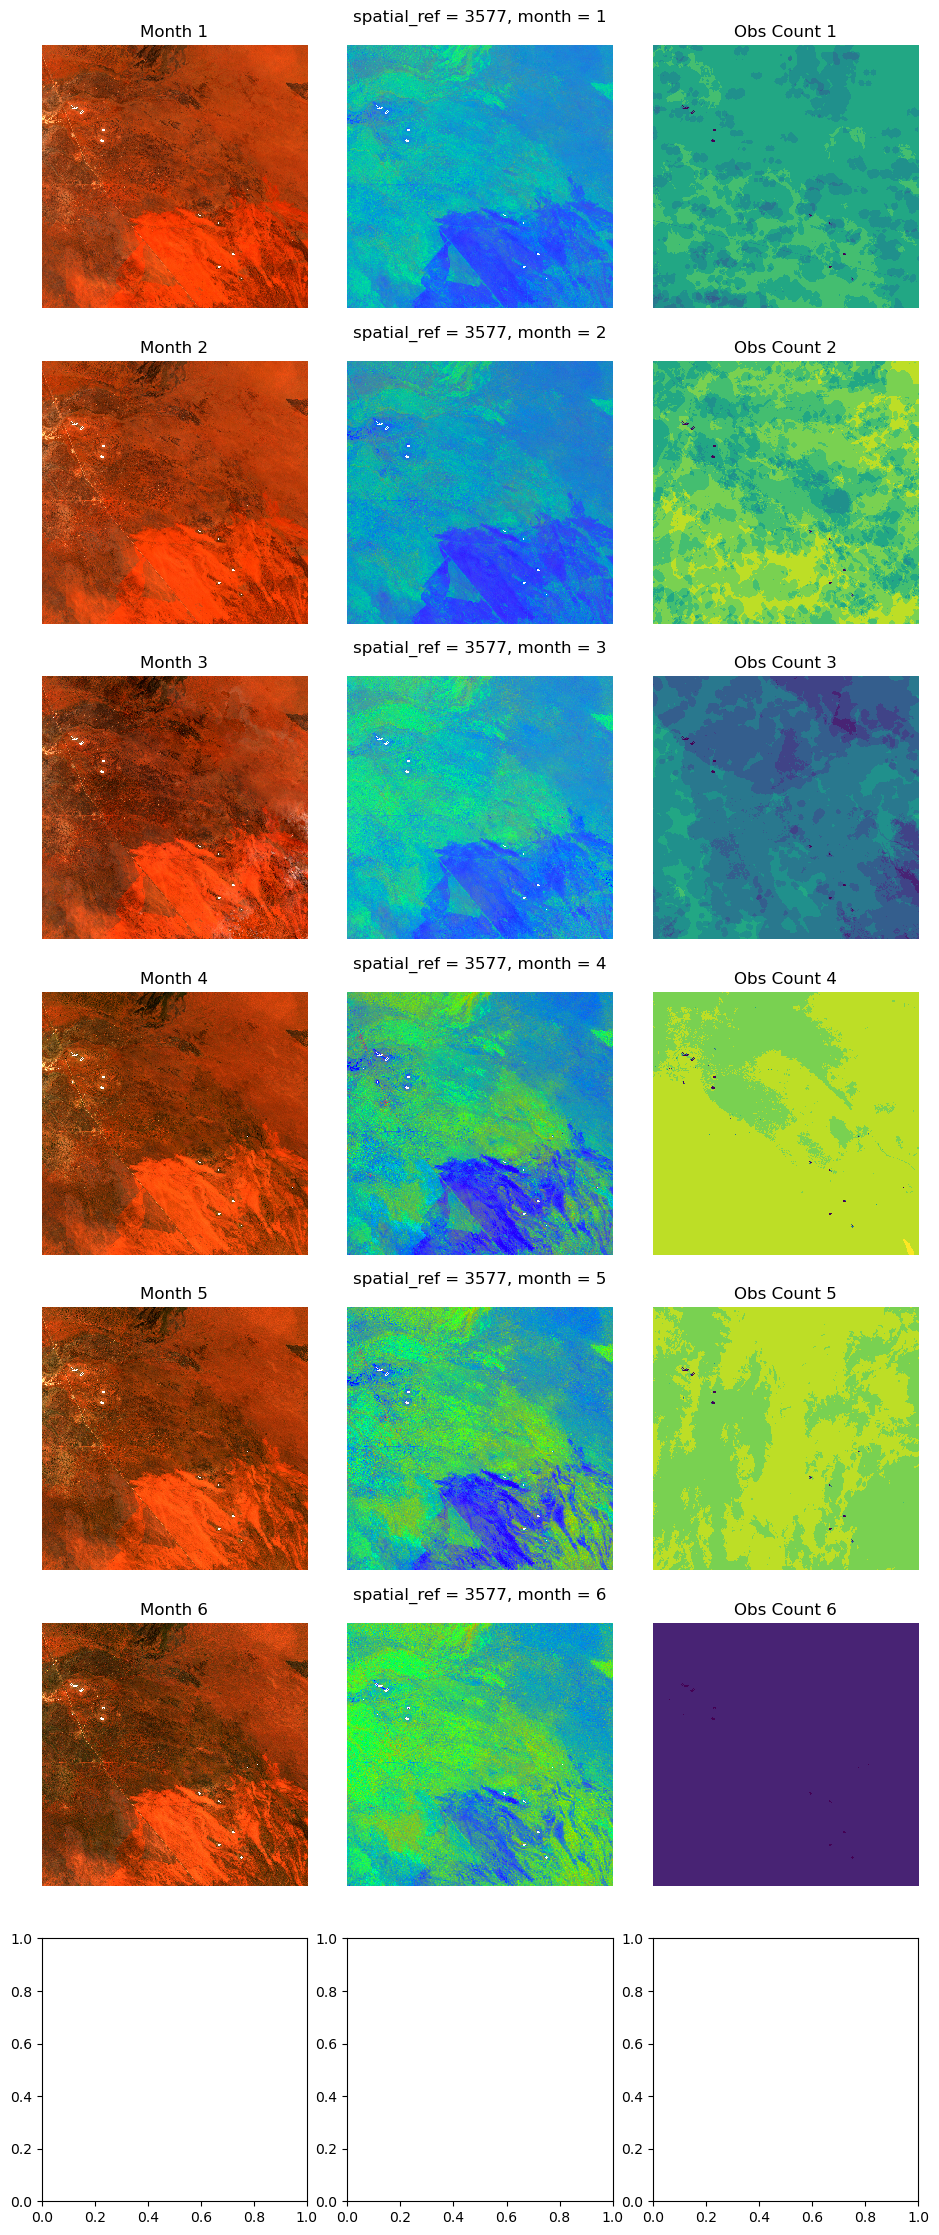

In [ ]:
n_steps = monthly_medians.sizes["month"]

# Use gridspec to add an extra column for the colorbar
fig = plt.figure(figsize=(4 * 3, 4 * n_steps))
gs = gridspec.GridSpec(nrows=n_steps, ncols=4, width_ratios=[1, 1, 1, 0.05])

axs = np.empty((n_steps, 3), dtype=object)
for i in range(n_steps):
    for j in range(3):
        axs[i, j] = fig.add_subplot(gs[i, j])

cmap = "viridis"
vmin = 0
vmax = 10

for i in range(n_steps):
    # True Colour RGB
    rgb_true = (
        xr.concat(
            [
                monthly_medians["nbart_red"].isel(month=i),
                monthly_medians["nbart_green"].isel(month=i),
                monthly_medians["nbart_blue"].isel(month=i),
            ],
            dim="band",
        )
        / 3000
    )
    # rgb_true = rgb_true.persist()
    rgb_true.plot.imshow(ax=axs[i, 0], robust=True, add_colorbar=False)
    axs[i, 0].set_title(f"Month {i+1}")
    axs[i, 0].axis("off")

    # FC RGB
    rgb_fc = (
        xr.concat(
            [
                monthly_medians["PV"].isel(month=i),
                monthly_medians["NPV"].isel(month=i),
                monthly_medians["BS"].isel(month=i),
            ],
            dim="band",
        )
        / 100
    )
    # rgb_fc = rgb_fc.persist()
    rgb_fc.plot.imshow(ax=axs[i, 1], robust=True, add_colorbar=False)
    axs[i, 1].axis("off")

    # Observation count
    obs_count = monthly_medians["obs_count"].isel(month=i)
    # obs_count = obs_count.persist()
    im = obs_count.plot.imshow(
        ax=axs[i, 2], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False
    )
    axs[i, 2].set_title(f"Obs Count {i+1}")
    axs[i, 2].axis("off")

# Add a single colorbar to the right
cax = fig.add_subplot(gs[:, 3])
cbar = fig.colorbar(im, cax=cax)
cbar.set_label("Observation Count")

axs[0, 0].set_ylabel("True Colour")
axs[0, 1].set_ylabel("FC RGB")
axs[0, 2].set_ylabel("Obs Count")

plt.show()


In [ ]:
# n_steps = monthly_medians.sizes["month"]

# fig, axs = plt.subplots(
#     n_steps,
#     3,
#     figsize=(12, 4 * n_steps),
#     sharex=True,
#     sharey=True,
#     layout="constrained",
# )

# cmap = "viridis"
# vmin = 0
# vmax = 10

# for i in range(n_steps):
#     # True Colour RGB
#     rgb_true = xr.concat(
#         [
#             monthly_medians["nbart_red"].isel(month=i),
#             monthly_medians["nbart_green"].isel(month=i),
#             monthly_medians["nbart_blue"].isel(month=i),
#         ],
#         dim="band",
#     )
#     rgb_true = rgb_true / 3000
#     rgb_true.plot.imshow(ax=axs[i, 0], robust=True, add_colorbar=False)
#     axs[i, 0].set_title(f"Month {i+1}")
#     axs[i, 0].axis("off")

#     # FC RGB
#     rgb_fc = xr.concat(
#         [
#             monthly_medians["PV"].isel(month=i),
#             monthly_medians["NPV"].isel(month=i),
#             monthly_medians["BS"].isel(month=i),
#         ],
#         dim="band",
#     )
#     rgb_fc = rgb_fc / 100
#     rgb_fc.plot.imshow(ax=axs[i, 1], robust=True, add_colorbar=False)
#     axs[i, 1].axis("off")

#     # Observation count
#     im = (
#         monthly_medians["obs_count"]
#         .isel(month=i)
#         .plot.imshow(ax=axs[i, 2], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False)
#     )
#     axs[i, 2].axis("off")

# cbar = fig.colorbar(
#     im, ax=axs[:, 2], orientation="horizontal", fraction=0.05, pad=0.07, aspect=40
# )

# cbar.set_label("observation count")

# axs[0, 0].set_ylabel("True Colour")
# axs[0, 1].set_ylabel("FC RGB")
# axs[0, 2].set_ylabel("Obs Count")

# plt.show()


In [ ]:
# time_idx = 0

# # Select DataArrays for plotting
# true_colour = xr.concat(
#     [
#         merged_ls["nbart_red"].isel(time=time_idx),
#         merged_ls["nbart_green"].isel(time=time_idx),
#         merged_ls["nbart_blue"].isel(time=time_idx),
#     ],
#     dim="band",
# )
# true_colour = true_colour.transpose("y", "x", "band")  # shape: (y, x, band)

# fc_colour = xr.concat(
#     [
#         merged_ls["BS"].isel(time=time_idx),
#         merged_ls["PV"].isel(time=time_idx),
#         merged_ls["NPV"].isel(time=time_idx),
#     ],
#     dim="band",
# )
# fc_colour = fc_colour.transpose("y", "x", "band")  # shape: (y, x, band)

# crs = ccrs.epsg(3577)  # Use your dataset's CRS


# fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={"projection": crs})

# # True colour plot
# axes[0].imshow(
#     true_colour.values / 3000,
#     extent=[merged_ls.x.min(), merged_ls.x.max(), merged_ls.y.min(), merged_ls.y.max()],
#     origin="upper",
# )
# axes[0].set_title("True Colour")
# axes[0].set_extent(
#     [merged_ls.x.min(), merged_ls.x.max(), merged_ls.y.min(), merged_ls.y.max()], crs
# )
# axes[0].coastlines()

# # FC composite plot
# axes[1].imshow(
#     fc_colour.values / 100,
#     extent=[merged_ls.x.min(), merged_ls.x.max(), merged_ls.y.min(), merged_ls.y.max()],
#     origin="upper",
# )
# axes[1].set_title("Fractional Cover Composite")
# axes[1].set_extent(
#     [merged_ls.x.min(), merged_ls.x.max(), merged_ls.y.min(), merged_ls.y.max()], crs
# )
# axes[1].coastlines()

# plt.tight_layout()
# plt.show()
